In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
mpl.rc('font', **{'size': 22})
# set whitegrid
sns.set_style("white")
plt.rcParams["font.family"] = "Times New Roman"
# set title font size to large and bold
plt.rcParams["axes.titlesize"] = 'large'
plt.rcParams["axes.titleweight"] = 'bold'

In [5]:
pivot_bleu.index

NameError: name 'pivot_bleu' is not defined

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


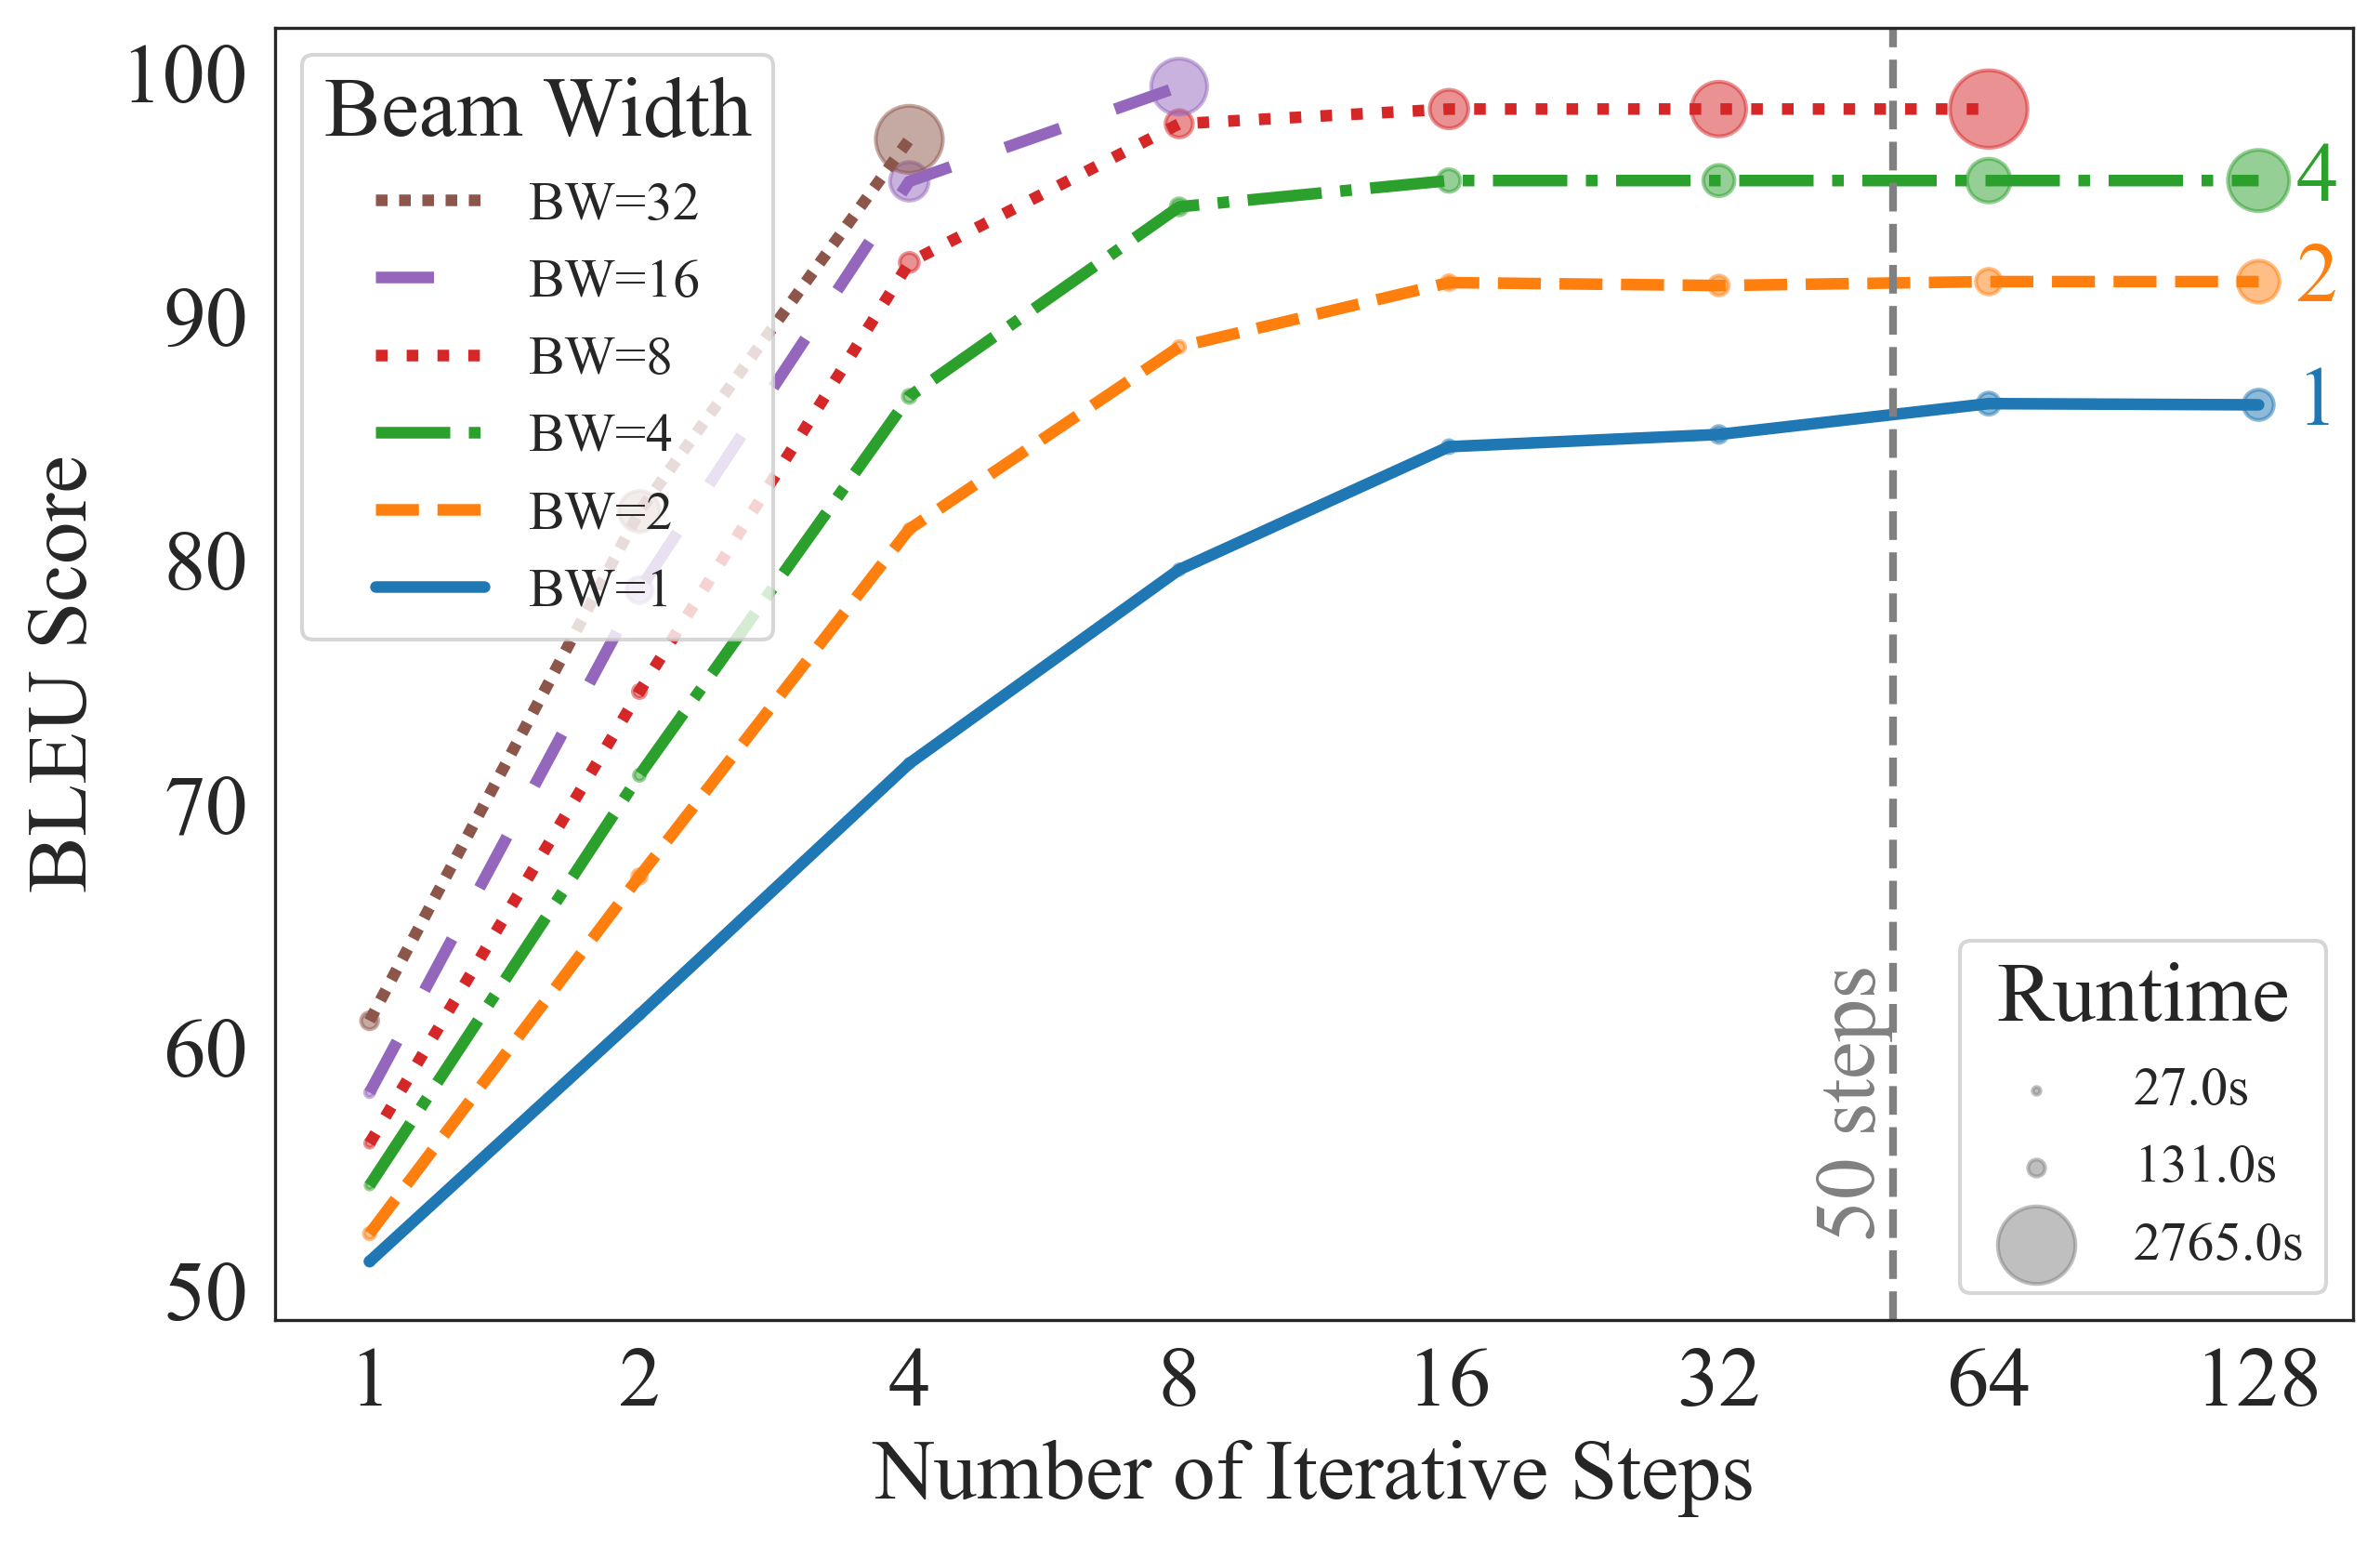

In [26]:
data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

pivot_bleu = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="bleu_score", aggfunc="mean"
)

pivot_runtime = data.pivot_table(
    index="num_steps", columns="sequence_beam_width", values="Runtime", aggfunc="mean"
)

pivot_bleu = pivot_bleu.sort_index().sort_index(axis=1)
pivot_runtime = pivot_runtime.reindex_like(pivot_bleu)

scale_factor = 100 / data["Runtime"].max()

#plt.style.use("seaborn-whitegrid")

bw_list = sorted(pivot_bleu.columns)
norm    = mpl.colors.Normalize(vmin=bw_list[0], vmax=bw_list[-1])
# cmap    = plt.get_cmap("Paired")
cmap = plt.get_cmap("tab10")
# cmap = plt.get_cmap("Set1")
# cmap = plt.get_cmap("Dark2")
linestyles = ['-', '--', '-.', ':', (0, (5, 5)),(0, (1, 1)),]

plt.figure(figsize=(9,6), dpi=300)
for i, bw in enumerate(bw_list):
    color = cmap(i)
    sizes = pivot_runtime[bw] * scale_factor * 4
    linestyle = linestyles[i % len(linestyles)]
    plt.plot(pivot_bleu.index, pivot_bleu[bw],
             color=color, label=f"BW={bw}", linewidth=3,linestyle=linestyle)
    plt.scatter(pivot_bleu.index, pivot_bleu[bw],
                s=sizes, alpha=0.5, color=color)
    # direct label at end
    plt.text(pivot_bleu.index.max()*1.1,
             pivot_bleu[bw].iloc[-1],
             str(bw), va="center", color=color)

# 50 steps annotation
plt.axvline(50, color="gray", ls="--", lw=2)
plt.text(50, 52, "50 steps", rotation=90,
         va="bottom", ha="right", color="gray")

# ticks & labels
plt.xscale("log")
plt.xticks(pivot_bleu.index, pivot_bleu.index.astype(str))
plt.xlabel("Number of Iterative Steps")
plt.ylabel("BLEU Score")
#plt.title("Trade-off between # steps, beam width, and runtime", fontsize=18)

# separate legends
# reverse the order of the legend
l1 = plt.legend(title="Beam Width", loc="upper left", fontsize=14, reverse=True)
size_vals = [data["Runtime"].min(),
             data["Runtime"].median(),
             data["Runtime"].max()]
handles = [ plt.scatter([],[], s=rt*scale_factor*4, color="gray", alpha=0.5)
            for rt in size_vals ]
labels  = [f"{rt:.1f}s" for rt in size_vals]
l2 = plt.legend(handles, labels, title="Runtime", loc="lower right", fontsize=14)
plt.gca().add_artist(l1)

plt.tight_layout()
plt.savefig("num_steps_vs_beam_width_runtime.pdf", bbox_inches='tight', pad_inches=0)
plt.show()



<Figure size 640x480 with 0 Axes>

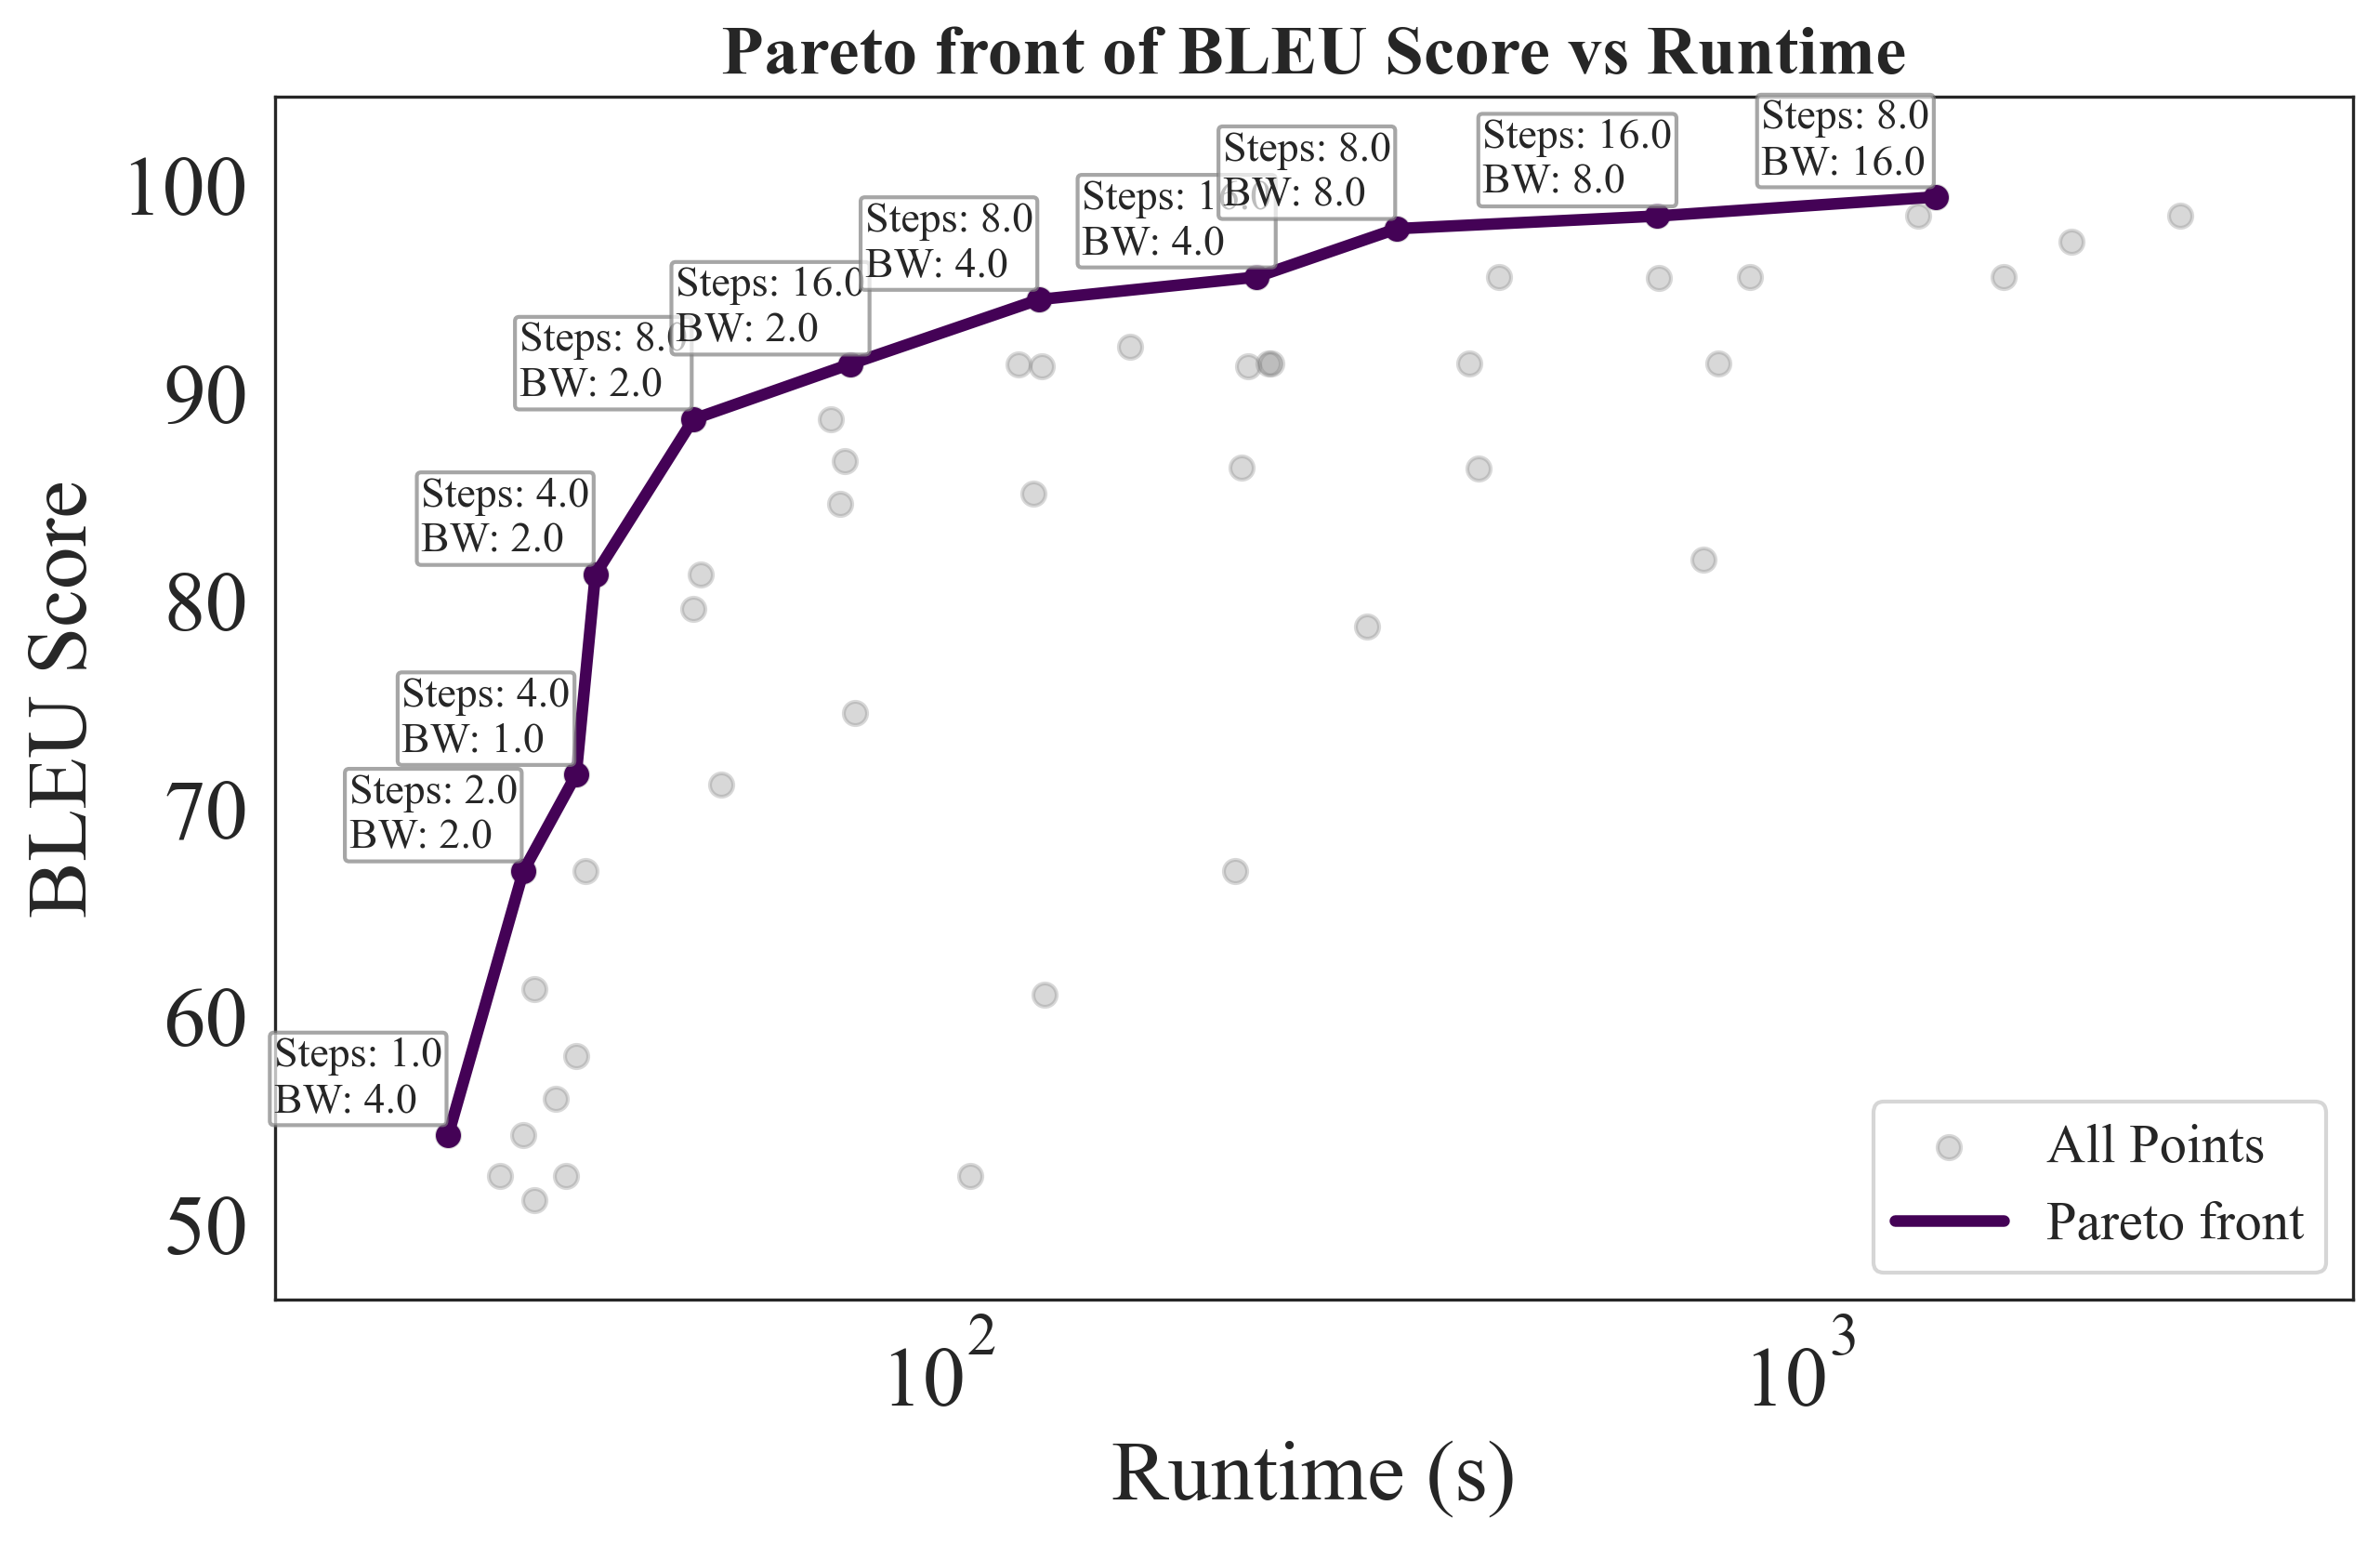

In [25]:
data = pd.read_csv("./data/num_steps_vs_beam_width.csv")
data = data[["num_steps", "sequence_beam_width", "bleu_score", "Runtime"]]

data.dropna(inplace=True)

data["num_steps"] = data["num_steps"].astype(int)
data["sequence_beam_width"] = data["sequence_beam_width"].astype(int)
data["Runtime"] = data["Runtime"].astype(float)

data_sorted = data.sort_values(["Runtime", "bleu_score"], ascending=[True, False])

pareto_front = []
last_bleu = -1
for _, row in data_sorted.iterrows():
    if row["bleu_score"] > last_bleu:
        pareto_front.append(row)
        last_bleu = row["bleu_score"]

pareto_front = pd.DataFrame(pareto_front)

plt.set_cmap("viridis")
virdis_last_color = plt.get_cmap("viridis")(1)
fig, ax = plt.subplots(figsize=(9, 6), dpi=300)
# set viridis colormap
ax.scatter(data["Runtime"], data["bleu_score"], alpha=0.3, label="All Points", color="gray")

ax.plot(
    pareto_front["Runtime"], pareto_front["bleu_score"], linewidth=3, label="Pareto front", color=virdis_last_color
)
ax.scatter(pareto_front["Runtime"], pareto_front["bleu_score"], s=30, color=virdis_last_color)

for idx, row in pareto_front.iterrows():
    ax.annotate(
        f"Steps: {row['num_steps']}\nBW: {row['sequence_beam_width']}",
        (row["Runtime"], row["bleu_score"]),
        textcoords="offset points",
        xytext=(-45, 6),
        ha="left",
        fontsize=11,               # make it a bit smaller if needed
        bbox=dict(boxstyle="round,pad=0.1", edgecolor="gray", facecolor="white", alpha=0.7),
        clip_on=False,            # let it draw outside the axes
    )

ax.set_xscale("log")
ax.set_xmargin(0.1)
ax.set_ymargin(0.1)

ax.set_xlabel("Runtime (s)")
ax.set_ylabel("BLEU Score")
ax.set_title("Pareto front of BLEU Score vs Runtime", fontsize=18)
ax.legend(loc="lower right", fontsize=14)

plt.tight_layout()   # <-- adjust margins
plt.savefig("pareto_front_bleu_vs_runtime.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


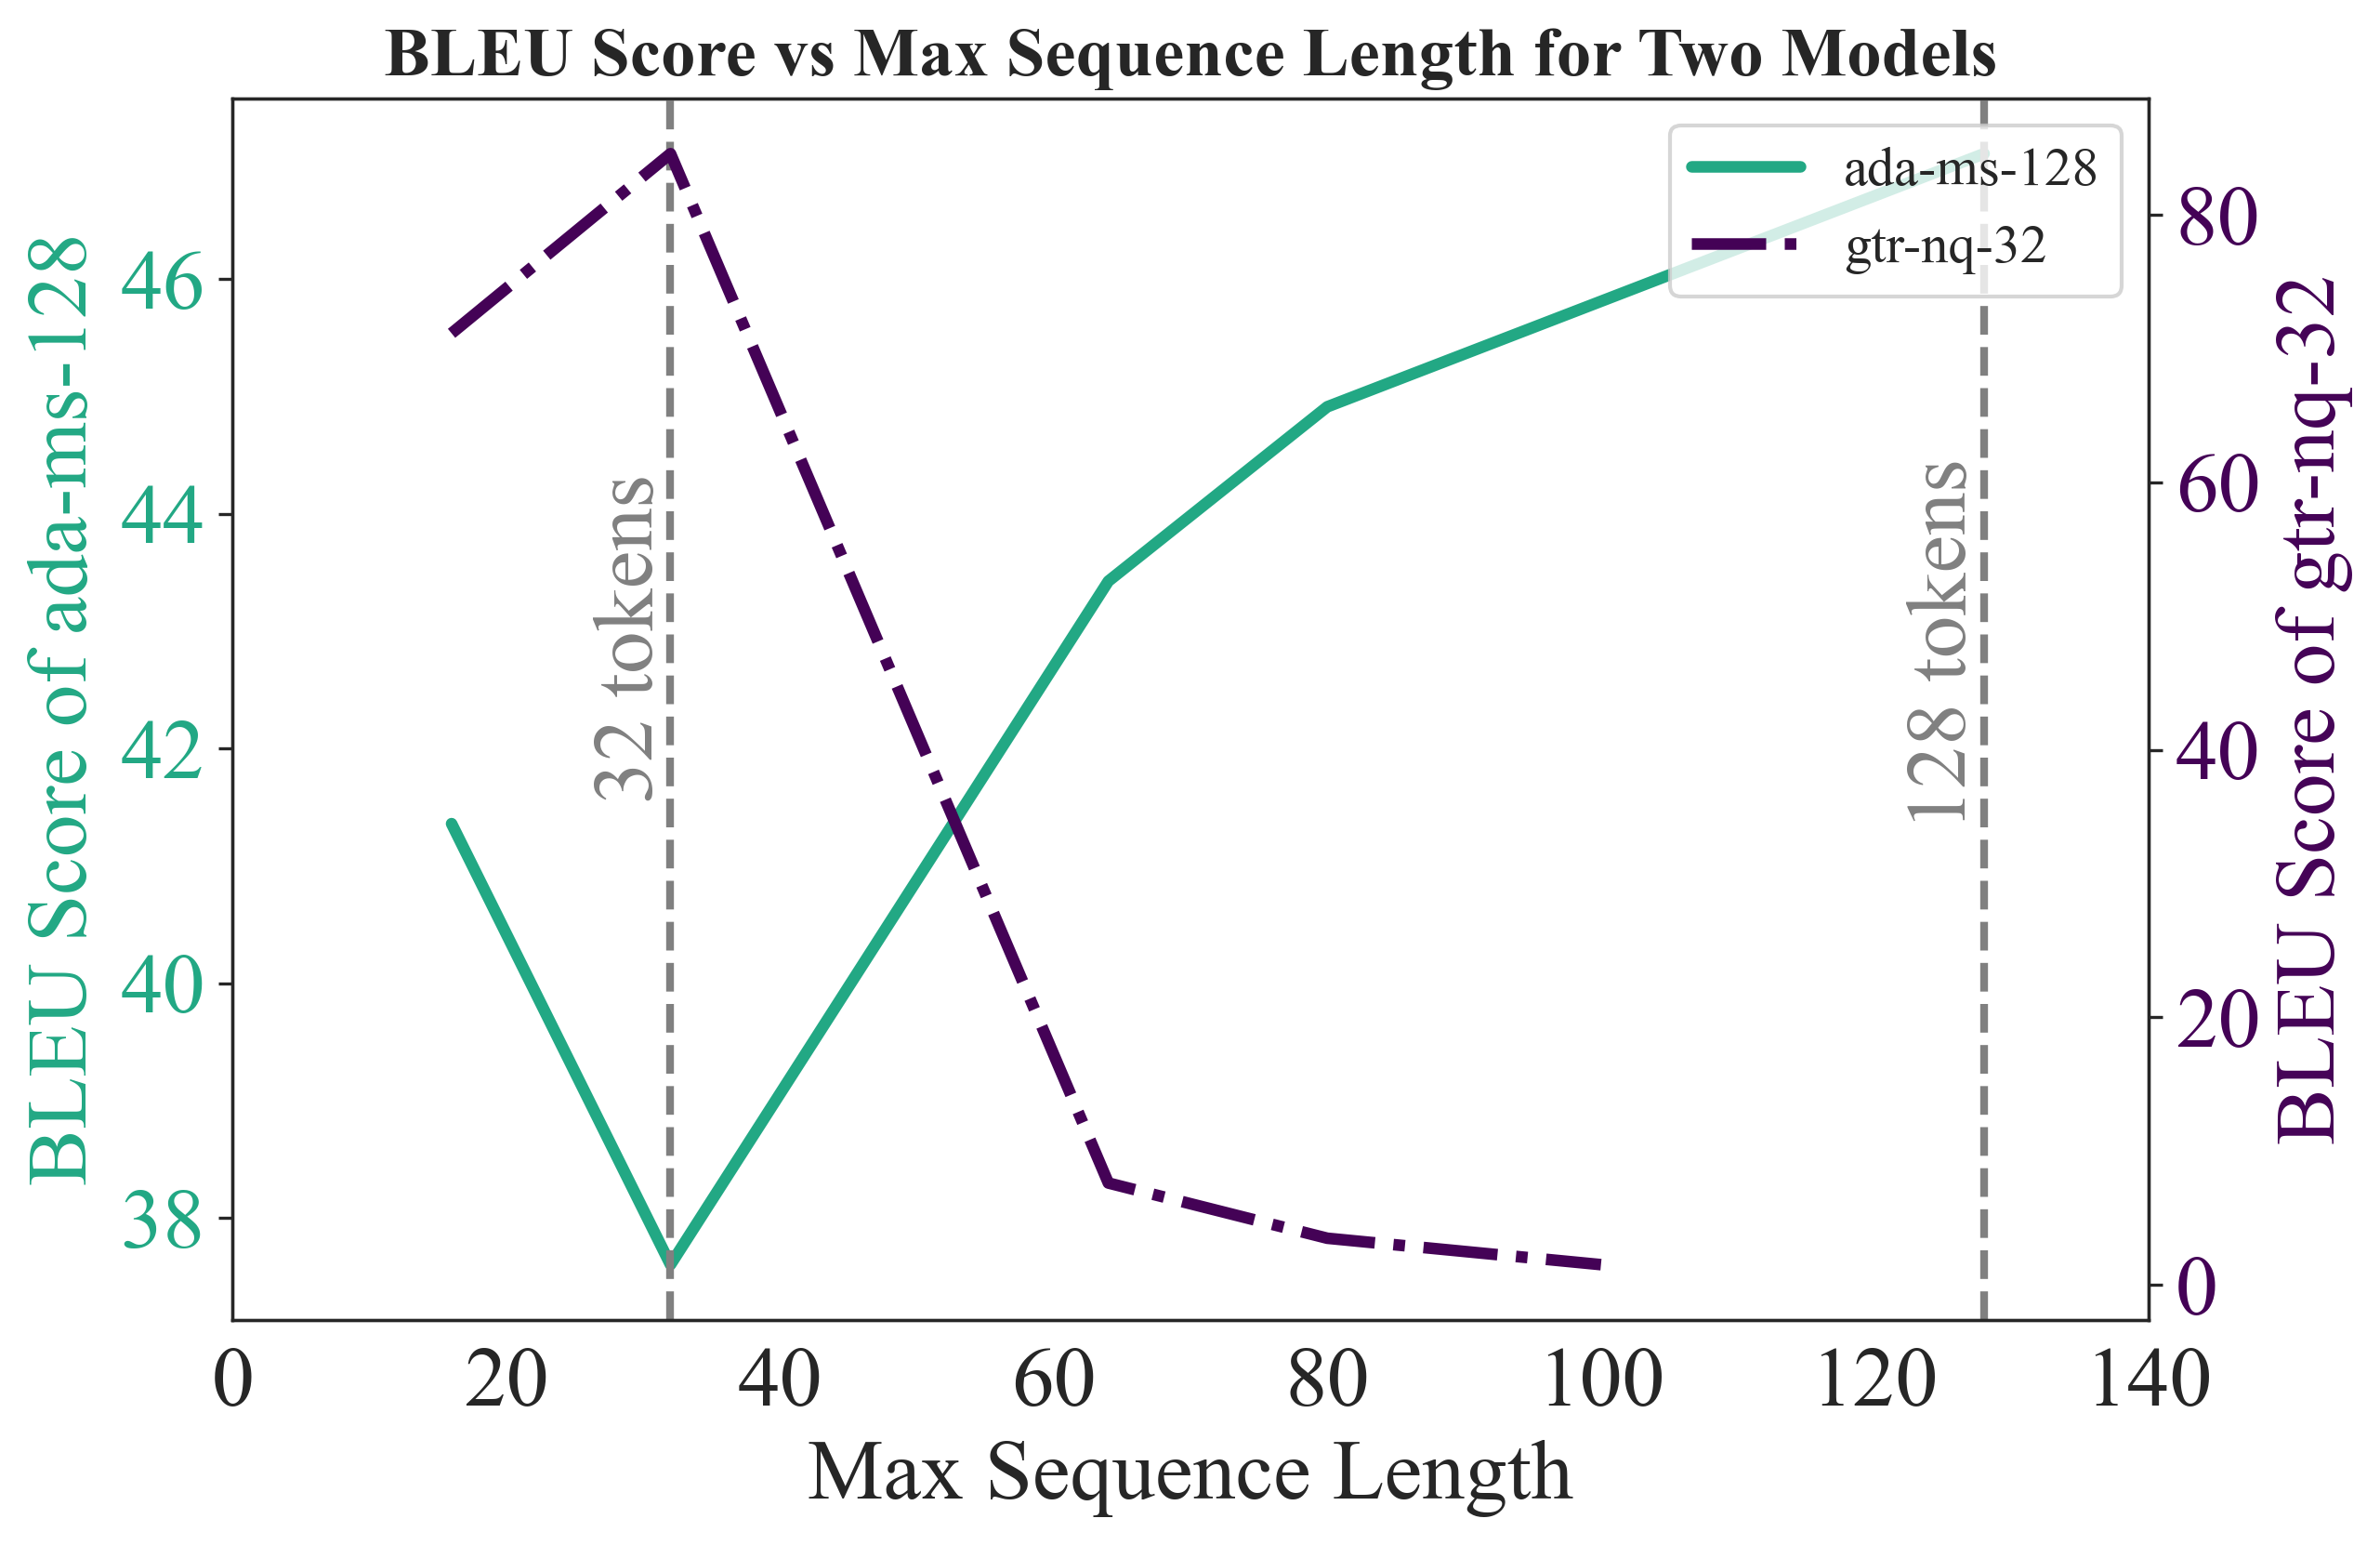

In [27]:
data = pd.read_csv("./data/seq_len_exps.csv")
name_map = {
    "model-sentence-transformers/gtr-t5-base_corrector-gtr-base_steps-50_beam-0_nucleus-False": "gtr-nq-32",
    "model-Xenova/text-embedding-ada-002_corrector-text-embedding-ada-002_steps-50_beam-0_nucleus-False": "ada-ms-128",
}
data["Name"] = data["Name"].map(name_map)
data["method"] = data["Name"]
data = data[["method", "max_seq_length", "bleu_score"]]

# Select two methods (assuming there are at least two)
methods = data['method'].unique()

# Create a figure and primary axis
fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)
virdis_last_color = plt.get_cmap("viridis")(1)
virdis_first_color = plt.get_cmap("viridis")(0.6)

linestyles = ['-', '--', '-.', ':', (0, (5, 5)),(0, (1, 1)),]

# Plot the first method as a line
method1 = methods[0]
method1_data = data[data['method'] == method1].sort_values(by="max_seq_length")
line1, = ax1.plot(method1_data["max_seq_length"], method1_data["bleu_score"], color=virdis_first_color, label=method1, linewidth=3,linestyle=linestyles[0])
ax1.set_xlabel("Max Sequence Length")
ax1.set_ylabel(f"BLEU Score of {method1}",color=virdis_first_color)
ax1.tick_params(axis='y', labelcolor=virdis_first_color)

# Create a secondary y-axis
ax2 = ax1.twinx()

# Plot the second method as a line
method2 = methods[1]
method2_data = data[data['method'] == method2].sort_values(by="max_seq_length")
line2, = ax2.plot(method2_data["max_seq_length"], method2_data["bleu_score"], color=virdis_last_color, label=method2, linewidth=3,linestyle=linestyles[2])
ax2.set_ylabel(f"BLEU Score of {method2}",color=virdis_last_color)
ax2.tick_params(axis='y',labelcolor=virdis_last_color)

# Combine the legends' handles and labels
lines = [line1, line2]
labels = [line1.get_label(), line2.get_label()]

# Create a combined legend from both axes
ax1.legend(lines, labels, loc='upper right', fontsize=14)

# Add a title
plt.title("BLEU Score vs Max Sequence Length for Two Models", fontsize=18)

# Set custom x-ticks, including at 32 and 128
current_xticks = ax1.get_xticks().tolist()  # Get the current list of x-ticks
new_xticks = sorted(set(current_xticks + [32, 128]))  # Combine with new ticks and sort
ax1.set_xticks(new_xticks)

# Add dashed vertical lines at 32 and 128
ax1.axvline(x=32, color='gray', linestyle='--', linewidth=2)
ax1.axvline(x=128, color='gray', linestyle='--', linewidth=2)
# remove the ticks at 32 and 128
ax1.set_xticks([tick for tick in new_xticks if tick not in [32, 128]])

plt.text(32, 36, "32 tokens", rotation=90,
         va="bottom", ha="right", color="gray")
plt.text(128, 34, "128 tokens", rotation=90,
         va="bottom", ha="right", color="gray")
# Show the plot
plt.tight_layout()
plt.savefig("seq_len_exps.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

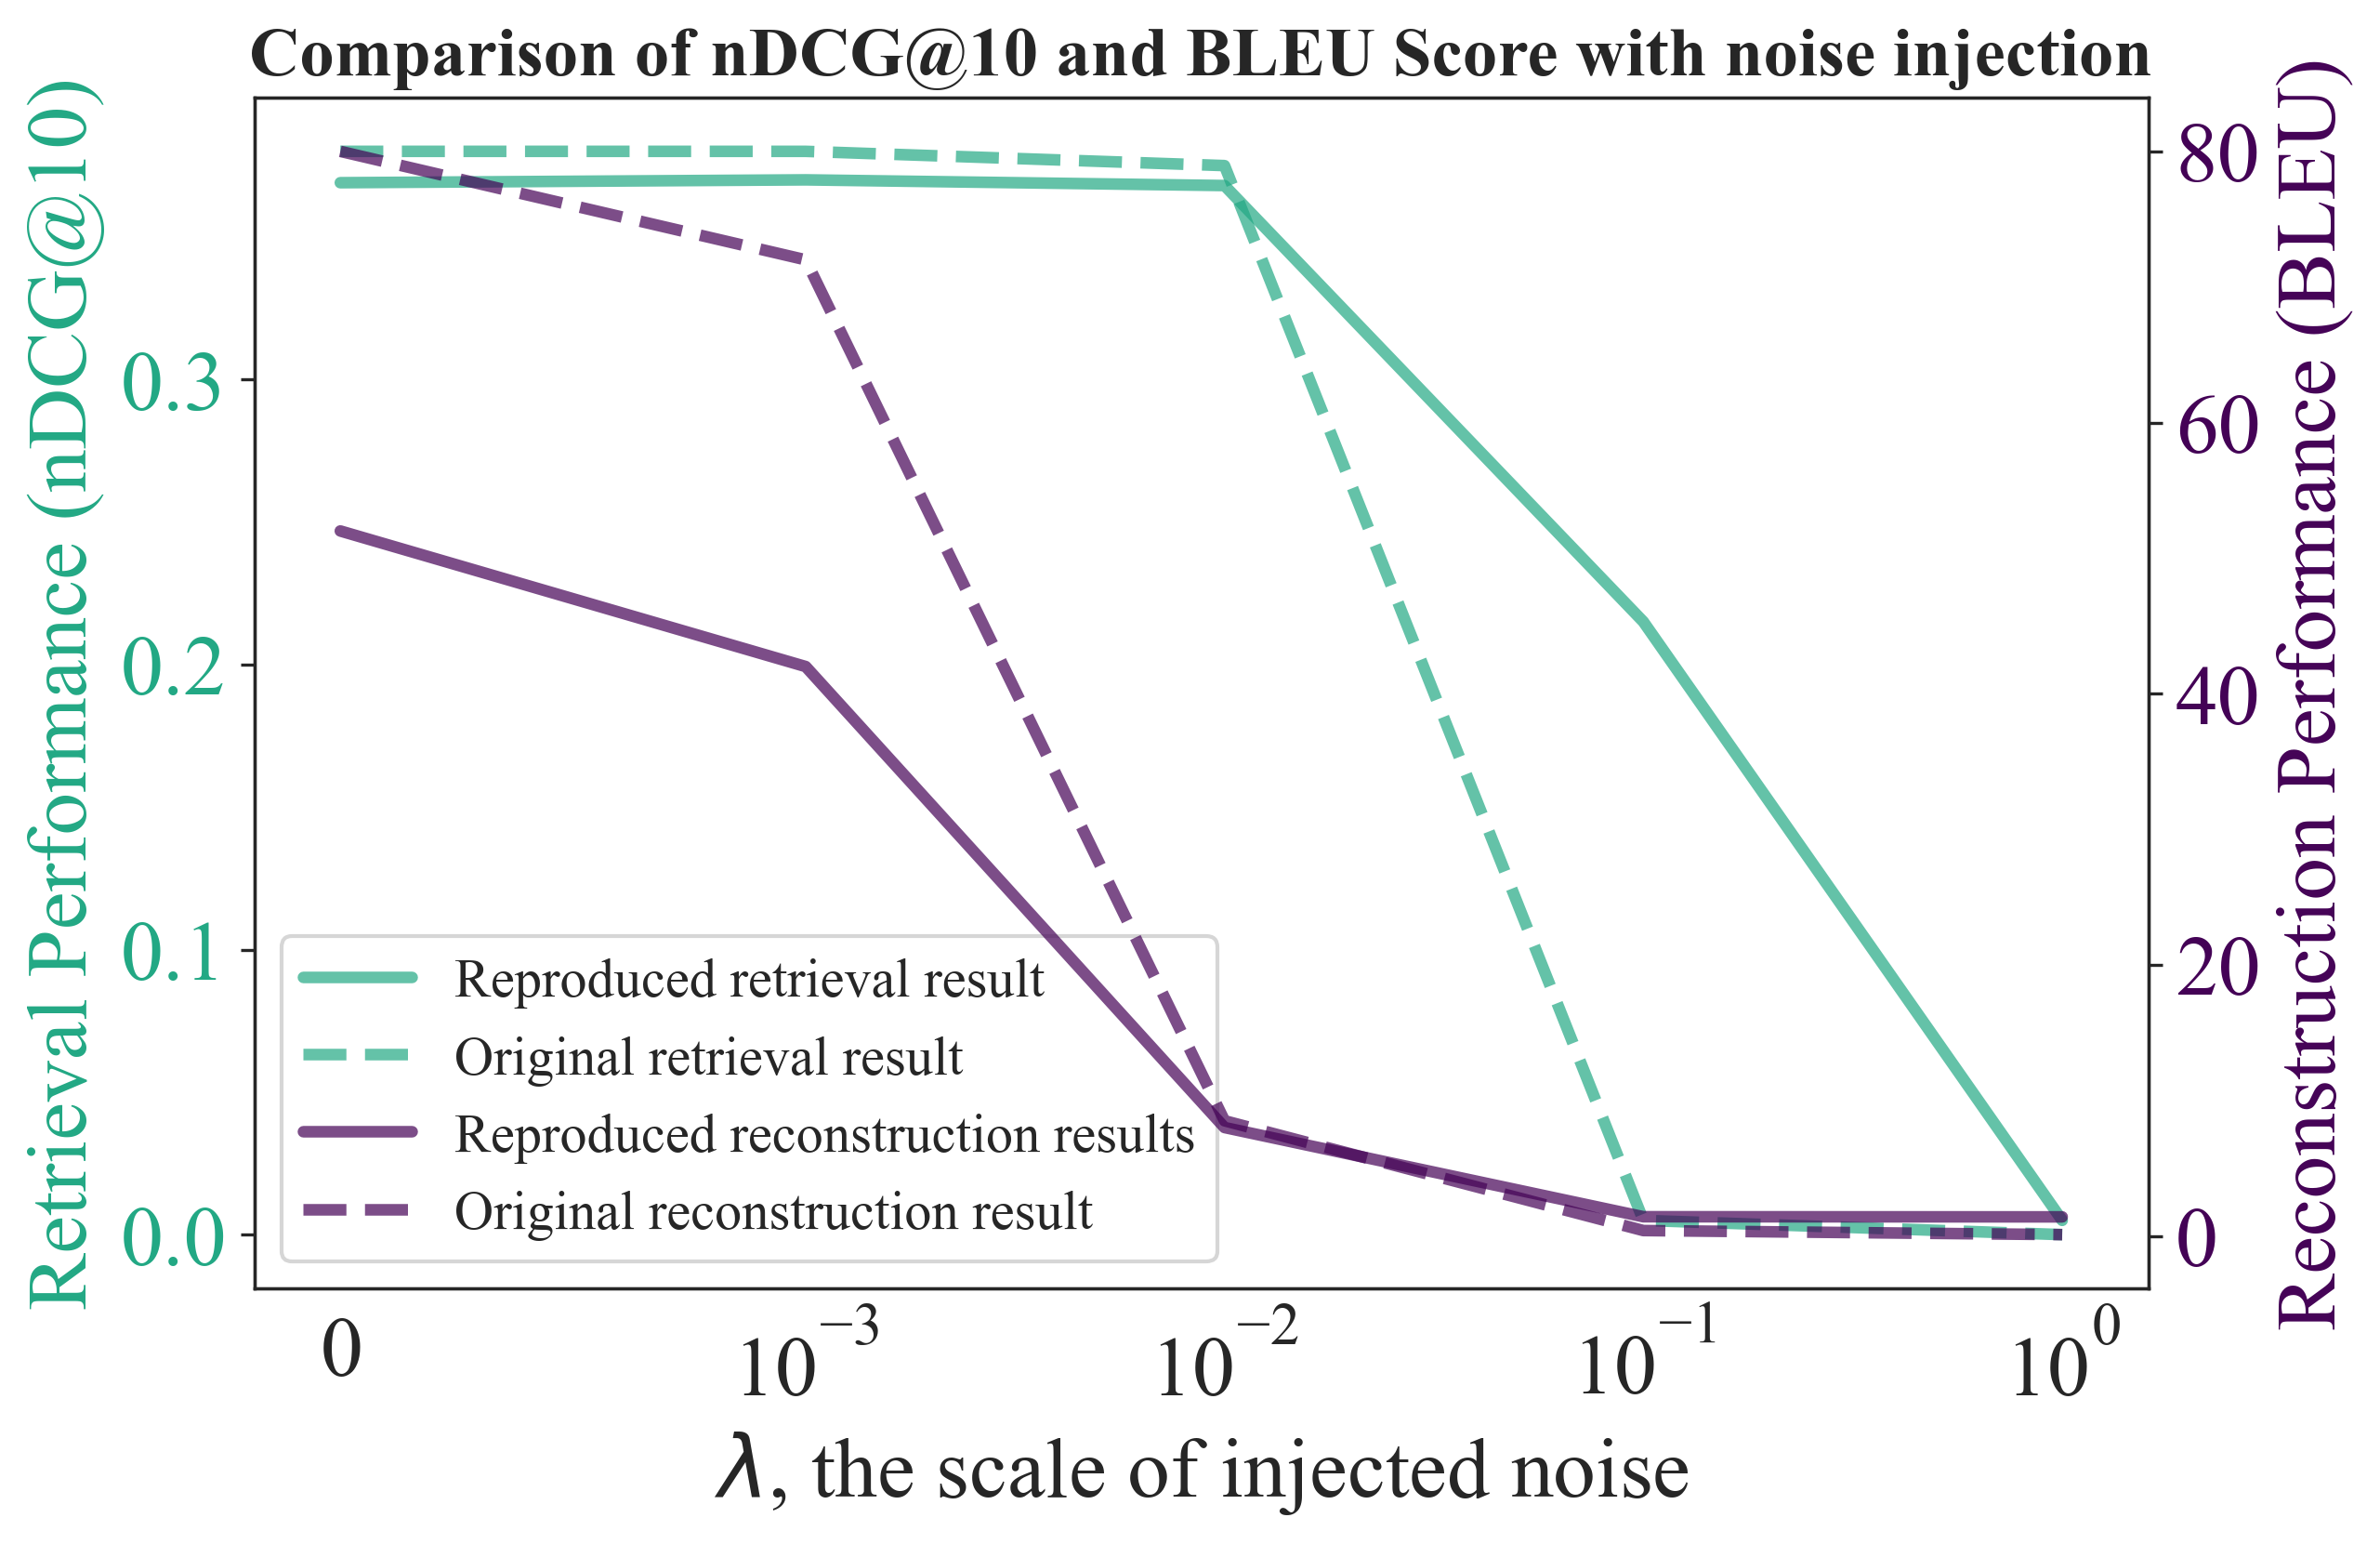

In [28]:
# --- your data here ---
noise = np.array([0, 1e-3, 1e-2, 1e-1, 1e0])

ndcg_reproduced = np.array([0.369, 0.370, 0.368, 0.215, 0.005])
ndcg_original   = np.array([0.380, 0.380, 0.375, 0.005, 0.000])

bleu_reproduced = np.array([52, 42.0,  8.0,  1.42, 1.41])
bleu_original   = np.array([80.0, 72.0,  8.5,  0.4, 0.10])
# ------------------------

fig, ax1 = plt.subplots(figsize=(9, 6), dpi=300)

virdis_first_color = plt.get_cmap("viridis")(0.6)
virdis_last_color = plt.get_cmap("viridis")(1)

# Retrieval on left axis
ax1.plot(noise, ndcg_reproduced,
         color=virdis_first_color, linestyle='-',
         label='Reproduced retrieval result', linewidth=3, alpha=0.7)
ax1.plot(noise, ndcg_original,
         color=virdis_first_color, linestyle='--',
         label='Original retrieval result', linewidth=3, alpha=0.7)
ax1.set_xlabel(r'$\lambda$, the scale of injected noise')
ax1.set_ylabel('Retrieval Performance (nDCG@10)', color=virdis_first_color)

# change y ticks color according to the axis of twinx
ax1.tick_params(axis='y', labelcolor=virdis_first_color)

# BLEU on right axis
ax2 = ax1.twinx()
ax2.plot(noise, bleu_reproduced,
         color=virdis_last_color, linestyle='-',
         label='Reproduced reconstruction results', linewidth=3, alpha=0.7)
ax2.plot(noise, bleu_original,
         color=virdis_last_color, linestyle='--',
         label='Original reconstruction result', alpha=0.7, linewidth=3)
ax2.set_ylabel('Reconstruction Performance (BLEU)', color=virdis_last_color)

# change y ticks color according to the axis
ax2.tick_params(axis='y', labelcolor=virdis_last_color)


# Symlog x-axis (zero + log ticks)
ax1.set_xscale('symlog', linthresh=1e-3)
ax1.set_xticks([0, 1e-3, 1e-2, 1e-1, 1e0])
#ax1.set_xticklabels(['0', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'], fontsize=18)

# Single combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower left', fontsize=14)

plt.title('Comparison of nDCG@10 and BLEU Score with noise injection', fontsize=18)
plt.tight_layout()
plt.savefig("retrieval_vs_bleu.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
